In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Net(nn.Module):
    def __init__(self , model):	#此处的model参数是已经加载了预训练参数的模型，方便继承预训练成果
        super(Net, self).__init__()
        #取掉model的后两层
        self.resnet_layer = nn.Sequential(*list(model.children())[:-2])
        self.dr_layer1=nn.modules.conv.Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn1=nn.modules.batchnorm.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer2=nn.modules.conv.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn2=nn.modules.batchnorm.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer3=nn.modules.conv.Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn3=nn.modules.batchnorm.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer4=nn.modules.conv.Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

        
    def forward(self, x):
        x = self.resnet_layer(x)
        x=self.dr_layer1(x)
        x=self.dr_bn1(x)
        x=self.dr_layer2(x)
        x=self.dr_bn2(x)
        x=self.dr_layer3(x)
        x=self.dr_bn3(x)
        x=self.dr_layer4(x)
        return x

In [3]:
resnet50 = models.resnet50(pretrained=True)
resnet50.conv1=nn.modules.conv.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = Net(resnet50) 
model=model.to(device)
# print(model)

In [4]:
data=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/data_reg_2000.npy')
data=np.expand_dims(data,axis=1)
# data=torch.from_numpy(data)
data=torch.FloatTensor(data)
# print(type(data[0][0][0]))
# print(data[0][0][0])
label=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/label_reg_2000.npy')
print(label.shape)
label=np.expand_dims(label,axis=1)
# label=torch.from_numpy(label)
label=torch.FloatTensor(label)
# print(label[0][0][0])
# print(data.shape,label.shape)
train_x=data[:-400]
test_x=data[-400:]
train_y=label[:-400]
test_y=label[-400:]
print(data.shape,label.shape)

(2000, 8, 8)
torch.Size([2000, 1, 256, 256]) torch.Size([2000, 1, 8, 8])


In [5]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [6]:
for epoch in range(1):
    for i,data in enumerate(train_loader):
        inputs, label=data
#         print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())
        print(len(data))
        print(data[0].shape)
        print(inputs.shape)
        print(label.shape)
        print(type(data[0][0][0][0]))
        break
        
        

2
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 8, 8])
<class 'torch.Tensor'>


In [7]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    
    history = []
    best_error = float('inf')
    best_epoch = 0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_error = 0.0
        valid_loss = 0.0
        valid_error = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += torch.mean(loss).item() 
            
            train_error+=torch.mean(torch.abs(outputs-labels)).item()
 
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                valid_loss += torch.mean(loss).item() 
                
                valid_error+=torch.mean(torch.abs(outputs-labels)).item()
 
 
        avg_train_loss = train_loss/train_data_size
        avg_train_error = train_error/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_error = valid_error/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_error, avg_valid_error])
 
        if best_error > avg_valid_error:
            best_error = avg_valid_error
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Training: Loss: {:.4f}, MAE: {:.4f}, \nValidation: Loss: {:.4f}, MAE: {:.4f}, \nTime: {:.4f}s".format(avg_train_loss, avg_train_error, avg_valid_loss, avg_valid_error, epoch_end-epoch_start
        ))
        print("Best Error for validation : {:.4f} at epoch {:03d}".format(best_error, best_epoch))
 
        torch.save(model, '2000_500_models/'+'rivers_model_'+str(epoch+1)+'.pt')
    return model, history


In [8]:
loss_func=nn.MSELoss()
num_epochs=500
optimizer = optim.Adam(model.parameters())


trained_model, history = train_and_valid(model, loss_func, optimizer, num_epochs)
torch.save(history, '2000_500_models/'+'rivers_history.pt')
 


Epoch: 1/500


/home/chase/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: Loss: 0.2805, MAE: 0.4737, 
Validation: Loss: 0.2428, MAE: 0.4606, 
Time: 18.9019s
Best Error for validation : 0.4606 at epoch 001
Epoch: 2/500
Training: Loss: 0.1741, MAE: 0.3884, 
Validation: Loss: 0.1109, MAE: 0.3020, 
Time: 18.9228s
Best Error for validation : 0.3020 at epoch 002
Epoch: 3/500
Training: Loss: 0.0931, MAE: 0.2777, 
Validation: Loss: 0.0536, MAE: 0.1984, 
Time: 18.9072s
Best Error for validation : 0.1984 at epoch 003
Epoch: 4/500
Training: Loss: 0.0353, MAE: 0.1598, 
Validation: Loss: 0.0346, MAE: 0.1404, 
Time: 18.9180s
Best Error for validation : 0.1404 at epoch 004
Epoch: 5/500
Training: Loss: 0.0128, MAE: 0.0881, 
Validation: Loss: 0.0196, MAE: 0.0992, 
Time: 18.9121s
Best Error for validation : 0.0992 at epoch 005
Epoch: 6/500
Training: Loss: 0.0077, MAE: 0.0665, 
Validation: Loss: 0.0193, MAE: 0.0989, 
Time: 18.9164s
Best Error for validation : 0.0989 at epoch 006
Epoch: 7/500
Training: Loss: 0.0057, MAE: 0.0579, 
Validation: Loss: 0.0187, MAE: 0.0966,

Training: Loss: 0.0007, MAE: 0.0209, 
Validation: Loss: 0.0156, MAE: 0.0880, 
Time: 18.9223s
Best Error for validation : 0.0864 at epoch 041
Epoch: 55/500
Training: Loss: 0.0007, MAE: 0.0209, 
Validation: Loss: 0.0149, MAE: 0.0859, 
Time: 18.9364s
Best Error for validation : 0.0859 at epoch 055
Epoch: 56/500
Training: Loss: 0.0007, MAE: 0.0205, 
Validation: Loss: 0.0156, MAE: 0.0884, 
Time: 18.9437s
Best Error for validation : 0.0859 at epoch 055
Epoch: 57/500
Training: Loss: 0.0007, MAE: 0.0208, 
Validation: Loss: 0.0152, MAE: 0.0875, 
Time: 18.9252s
Best Error for validation : 0.0859 at epoch 055
Epoch: 58/500
Training: Loss: 0.0007, MAE: 0.0202, 
Validation: Loss: 0.0149, MAE: 0.0861, 
Time: 18.9225s
Best Error for validation : 0.0859 at epoch 055
Epoch: 59/500
Training: Loss: 0.0007, MAE: 0.0200, 
Validation: Loss: 0.0151, MAE: 0.0878, 
Time: 18.9210s
Best Error for validation : 0.0859 at epoch 055
Epoch: 60/500
Training: Loss: 0.0007, MAE: 0.0198, 
Validation: Loss: 0.0148, MAE: 0

Training: Loss: 0.0006, MAE: 0.0184, 
Validation: Loss: 0.0146, MAE: 0.0852, 
Time: 18.9328s
Best Error for validation : 0.0834 at epoch 104
Epoch: 108/500
Training: Loss: 0.0006, MAE: 0.0183, 
Validation: Loss: 0.0147, MAE: 0.0861, 
Time: 18.9202s
Best Error for validation : 0.0834 at epoch 104
Epoch: 109/500
Training: Loss: 0.0006, MAE: 0.0186, 
Validation: Loss: 0.0145, MAE: 0.0854, 
Time: 18.9525s
Best Error for validation : 0.0834 at epoch 104
Epoch: 110/500
Training: Loss: 0.0006, MAE: 0.0185, 
Validation: Loss: 0.0144, MAE: 0.0836, 
Time: 18.9239s
Best Error for validation : 0.0834 at epoch 104
Epoch: 111/500
Training: Loss: 0.0005, MAE: 0.0174, 
Validation: Loss: 0.0143, MAE: 0.0835, 
Time: 18.9273s
Best Error for validation : 0.0834 at epoch 104
Epoch: 112/500
Training: Loss: 0.0005, MAE: 0.0171, 
Validation: Loss: 0.0140, MAE: 0.0825, 
Time: 18.9519s
Best Error for validation : 0.0825 at epoch 112
Epoch: 113/500
Training: Loss: 0.0005, MAE: 0.0168, 
Validation: Loss: 0.0147, 

Training: Loss: 0.0003, MAE: 0.0140, 
Validation: Loss: 0.0109, MAE: 0.0711, 
Time: 18.9291s
Best Error for validation : 0.0711 at epoch 160
Epoch: 161/500
Training: Loss: 0.0003, MAE: 0.0137, 
Validation: Loss: 0.0111, MAE: 0.0723, 
Time: 18.8997s
Best Error for validation : 0.0711 at epoch 160
Epoch: 162/500
Training: Loss: 0.0003, MAE: 0.0135, 
Validation: Loss: 0.0109, MAE: 0.0714, 
Time: 18.9030s
Best Error for validation : 0.0711 at epoch 160
Epoch: 163/500
Training: Loss: 0.0003, MAE: 0.0130, 
Validation: Loss: 0.0111, MAE: 0.0718, 
Time: 18.9266s
Best Error for validation : 0.0711 at epoch 160
Epoch: 164/500
Training: Loss: 0.0003, MAE: 0.0132, 
Validation: Loss: 0.0115, MAE: 0.0731, 
Time: 18.9149s
Best Error for validation : 0.0711 at epoch 160
Epoch: 165/500
Training: Loss: 0.0004, MAE: 0.0148, 
Validation: Loss: 0.0109, MAE: 0.0718, 
Time: 18.9158s
Best Error for validation : 0.0711 at epoch 160
Epoch: 166/500
Training: Loss: 0.0003, MAE: 0.0140, 
Validation: Loss: 0.0114, 

Training: Loss: 0.0002, MAE: 0.0120, 
Validation: Loss: 0.0109, MAE: 0.0707, 
Time: 18.9111s
Best Error for validation : 0.0706 at epoch 179
Epoch: 214/500
Training: Loss: 0.0003, MAE: 0.0126, 
Validation: Loss: 0.0108, MAE: 0.0714, 
Time: 18.9173s
Best Error for validation : 0.0706 at epoch 179
Epoch: 215/500
Training: Loss: 0.0002, MAE: 0.0120, 
Validation: Loss: 0.0114, MAE: 0.0731, 
Time: 18.9201s
Best Error for validation : 0.0706 at epoch 179
Epoch: 216/500
Training: Loss: 0.0003, MAE: 0.0129, 
Validation: Loss: 0.0109, MAE: 0.0723, 
Time: 18.9207s
Best Error for validation : 0.0706 at epoch 179
Epoch: 217/500
Training: Loss: 0.0003, MAE: 0.0129, 
Validation: Loss: 0.0108, MAE: 0.0718, 
Time: 18.9299s
Best Error for validation : 0.0706 at epoch 179
Epoch: 218/500
Training: Loss: 0.0003, MAE: 0.0126, 
Validation: Loss: 0.0108, MAE: 0.0709, 
Time: 18.9374s
Best Error for validation : 0.0706 at epoch 179
Epoch: 219/500
Training: Loss: 0.0002, MAE: 0.0121, 
Validation: Loss: 0.0107, 

Training: Loss: 0.0002, MAE: 0.0123, 
Validation: Loss: 0.0111, MAE: 0.0719, 
Time: 18.8893s
Best Error for validation : 0.0704 at epoch 247
Epoch: 267/500
Training: Loss: 0.0002, MAE: 0.0115, 
Validation: Loss: 0.0111, MAE: 0.0717, 
Time: 18.9154s
Best Error for validation : 0.0704 at epoch 247
Epoch: 268/500
Training: Loss: 0.0002, MAE: 0.0115, 
Validation: Loss: 0.0110, MAE: 0.0726, 
Time: 18.9196s
Best Error for validation : 0.0704 at epoch 247
Epoch: 269/500
Training: Loss: 0.0002, MAE: 0.0113, 
Validation: Loss: 0.0111, MAE: 0.0714, 
Time: 18.9220s
Best Error for validation : 0.0704 at epoch 247
Epoch: 270/500
Training: Loss: 0.0002, MAE: 0.0115, 
Validation: Loss: 0.0110, MAE: 0.0713, 
Time: 18.9034s
Best Error for validation : 0.0704 at epoch 247
Epoch: 271/500
Training: Loss: 0.0003, MAE: 0.0127, 
Validation: Loss: 0.0113, MAE: 0.0723, 
Time: 18.8992s
Best Error for validation : 0.0704 at epoch 247
Epoch: 272/500
Training: Loss: 0.0002, MAE: 0.0110, 
Validation: Loss: 0.0110, 

Training: Loss: 0.0001, MAE: 0.0090, 
Validation: Loss: 0.0108, MAE: 0.0717, 
Time: 18.9000s
Best Error for validation : 0.0704 at epoch 247
Epoch: 320/500
Training: Loss: 0.0001, MAE: 0.0091, 
Validation: Loss: 0.0108, MAE: 0.0710, 
Time: 18.9118s
Best Error for validation : 0.0704 at epoch 247
Epoch: 321/500
Training: Loss: 0.0001, MAE: 0.0092, 
Validation: Loss: 0.0109, MAE: 0.0712, 
Time: 18.9119s
Best Error for validation : 0.0704 at epoch 247
Epoch: 322/500
Training: Loss: 0.0001, MAE: 0.0095, 
Validation: Loss: 0.0107, MAE: 0.0706, 
Time: 18.9115s
Best Error for validation : 0.0704 at epoch 247
Epoch: 323/500
Training: Loss: 0.0001, MAE: 0.0084, 
Validation: Loss: 0.0108, MAE: 0.0712, 
Time: 18.9068s
Best Error for validation : 0.0704 at epoch 247
Epoch: 324/500
Training: Loss: 0.0001, MAE: 0.0090, 
Validation: Loss: 0.0108, MAE: 0.0711, 
Time: 18.9050s
Best Error for validation : 0.0704 at epoch 247
Epoch: 325/500
Training: Loss: 0.0001, MAE: 0.0080, 
Validation: Loss: 0.0107, 

Training: Loss: 0.0001, MAE: 0.0085, 
Validation: Loss: 0.0110, MAE: 0.0722, 
Time: 18.9130s
Best Error for validation : 0.0704 at epoch 357
Epoch: 373/500
Training: Loss: 0.0001, MAE: 0.0083, 
Validation: Loss: 0.0108, MAE: 0.0707, 
Time: 18.9009s
Best Error for validation : 0.0704 at epoch 357
Epoch: 374/500
Training: Loss: 0.0001, MAE: 0.0085, 
Validation: Loss: 0.0108, MAE: 0.0710, 
Time: 18.9195s
Best Error for validation : 0.0704 at epoch 357
Epoch: 375/500
Training: Loss: 0.0001, MAE: 0.0087, 
Validation: Loss: 0.0109, MAE: 0.0713, 
Time: 18.9095s
Best Error for validation : 0.0704 at epoch 357
Epoch: 376/500
Training: Loss: 0.0001, MAE: 0.0093, 
Validation: Loss: 0.0109, MAE: 0.0713, 
Time: 18.9144s
Best Error for validation : 0.0704 at epoch 357
Epoch: 377/500
Training: Loss: 0.0002, MAE: 0.0098, 
Validation: Loss: 0.0107, MAE: 0.0704, 
Time: 18.9062s
Best Error for validation : 0.0704 at epoch 377
Epoch: 378/500
Training: Loss: 0.0001, MAE: 0.0094, 
Validation: Loss: 0.0110, 

Training: Loss: 0.0001, MAE: 0.0093, 
Validation: Loss: 0.0112, MAE: 0.0726, 
Time: 18.8933s
Best Error for validation : 0.0704 at epoch 377
Epoch: 426/500
Training: Loss: 0.0001, MAE: 0.0085, 
Validation: Loss: 0.0110, MAE: 0.0715, 
Time: 18.9065s
Best Error for validation : 0.0704 at epoch 377
Epoch: 427/500
Training: Loss: 0.0001, MAE: 0.0088, 
Validation: Loss: 0.0111, MAE: 0.0720, 
Time: 18.9348s
Best Error for validation : 0.0704 at epoch 377
Epoch: 428/500
Training: Loss: 0.0001, MAE: 0.0087, 
Validation: Loss: 0.0116, MAE: 0.0751, 
Time: 18.9058s
Best Error for validation : 0.0704 at epoch 377
Epoch: 429/500
Training: Loss: 0.0001, MAE: 0.0077, 
Validation: Loss: 0.0113, MAE: 0.0725, 
Time: 18.9127s
Best Error for validation : 0.0704 at epoch 377
Epoch: 430/500
Training: Loss: 0.0001, MAE: 0.0086, 
Validation: Loss: 0.0116, MAE: 0.0746, 
Time: 18.9088s
Best Error for validation : 0.0704 at epoch 377
Epoch: 431/500
Training: Loss: 0.0001, MAE: 0.0079, 
Validation: Loss: 0.0112, 

Training: Loss: 0.0001, MAE: 0.0076, 
Validation: Loss: 0.0111, MAE: 0.0718, 
Time: 18.9051s
Best Error for validation : 0.0704 at epoch 377
Epoch: 479/500
Training: Loss: 0.0001, MAE: 0.0075, 
Validation: Loss: 0.0111, MAE: 0.0717, 
Time: 18.9210s
Best Error for validation : 0.0704 at epoch 377
Epoch: 480/500
Training: Loss: 0.0001, MAE: 0.0070, 
Validation: Loss: 0.0112, MAE: 0.0720, 
Time: 18.9098s
Best Error for validation : 0.0704 at epoch 377
Epoch: 481/500
Training: Loss: 0.0001, MAE: 0.0077, 
Validation: Loss: 0.0112, MAE: 0.0718, 
Time: 18.9111s
Best Error for validation : 0.0704 at epoch 377
Epoch: 482/500
Training: Loss: 0.0001, MAE: 0.0074, 
Validation: Loss: 0.0118, MAE: 0.0731, 
Time: 18.8975s
Best Error for validation : 0.0704 at epoch 377
Epoch: 483/500
Training: Loss: 0.0001, MAE: 0.0078, 
Validation: Loss: 0.0112, MAE: 0.0720, 
Time: 18.8919s
Best Error for validation : 0.0704 at epoch 377
Epoch: 484/500
Training: Loss: 0.0001, MAE: 0.0072, 
Validation: Loss: 0.0113, 

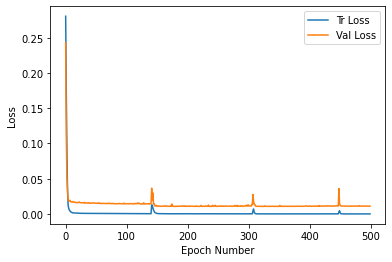

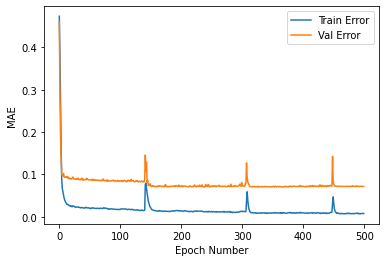

In [9]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig('2000_500_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Train Error', 'Val Error'])
plt.xlabel('Epoch Number')
plt.ylabel('MAE')
# plt.ylim(0, 1)
plt.savefig('2000_500_error_curve.png')
plt.show()

In [19]:
test_x[0].shape
test_sample=torch.unsqueeze(test_x[0],0).to(device)

In [24]:
result=model(test_sample)
result

tensor([[[[0.5631, 0.1613, 0.2831, 0.1240, 0.8366, 0.5690, 0.7362, 0.4886],
          [0.0742, 0.9606, 0.4491, 0.4479, 0.6530, 0.5563, 0.1661, 0.4700],
          [0.5010, 0.6659, 0.5144, 0.3786, 0.7997, 0.0676, 0.6715, 0.7638],
          [0.0919, 0.0576, 0.5811, 0.3686, 0.8451, 0.2421, 0.0748, 0.8471],
          [0.6665, 0.0609, 0.0922, 0.0808, 0.6040, 0.8294, 0.3668, 0.0388],
          [0.8125, 0.7152, 0.5228, 0.8383, 0.3344, 0.7030, 0.4074, 0.5135],
          [0.6818, 0.2215, 0.6831, 0.5449, 0.5332, 0.6988, 0.5042, 0.5323],
          [0.2559, 0.6910, 0.2404, 0.8101, 0.6730, 0.6057, 0.1841, 0.7367]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)

In [26]:
result_sample=torch.unsqueeze(test_y[0],0).to(device)

In [27]:
result_sample

tensor([[[[0.6125, 0.1979, 0.2406, 0.1793, 0.8570, 0.5676, 0.6852, 0.4797],
          [0.0252, 0.9620, 0.4662, 0.4342, 0.5943, 0.5465, 0.0063, 0.4676],
          [0.3534, 0.7350, 0.4841, 0.4371, 0.8043, 0.1661, 0.6479, 0.6845],
          [0.0677, 0.0090, 0.5210, 0.4059, 0.7147, 0.2345, 0.0966, 0.7759],
          [0.5437, 0.2324, 0.0677, 0.1109, 0.7154, 0.7373, 0.4614, 0.0300],
          [0.8700, 0.7075, 0.4881, 0.9723, 0.4534, 0.6483, 0.3494, 0.5438],
          [0.6012, 0.1513, 0.7136, 0.3365, 0.5521, 0.9445, 0.4872, 0.5929],
          [0.2073, 0.6932, 0.2435, 0.9906, 0.8046, 0.4374, 0.2315, 0.7283]]]],
       device='cuda:0')

In [28]:
result_sample-result

tensor([[[[ 0.0495,  0.0366, -0.0426,  0.0553,  0.0203, -0.0014, -0.0511,
           -0.0089],
          [-0.0490,  0.0014,  0.0172, -0.0137, -0.0586, -0.0098, -0.1598,
           -0.0024],
          [-0.1476,  0.0691, -0.0304,  0.0585,  0.0046,  0.0985, -0.0235,
           -0.0793],
          [-0.0242, -0.0486, -0.0601,  0.0373, -0.1304, -0.0076,  0.0218,
           -0.0712],
          [-0.1228,  0.1716, -0.0245,  0.0301,  0.1114, -0.0922,  0.0946,
           -0.0089],
          [ 0.0575, -0.0077, -0.0346,  0.1340,  0.1190, -0.0547, -0.0580,
            0.0302],
          [-0.0806, -0.0702,  0.0305, -0.2084,  0.0189,  0.2457, -0.0170,
            0.0606],
          [-0.0486,  0.0022,  0.0031,  0.1805,  0.1316, -0.1683,  0.0474,
           -0.0084]]]], device='cuda:0', grad_fn=<SubBackward0>)

In [29]:
history[-1]

array([9.16668803e-05, 1.10731925e-02, 7.42801220e-03, 7.17941964e-02])